# Schätzung der Hauspreise mit Hilfe linearer Regression

**Herangehensweise:**
- Daten einlesen
- Daten in training und test aufteilen
- NaN-Werte behandeln: Aus den Trainingsdaten entfernen, mit 0 ersetzen, den Mittelwert des Attributes setzen
- Kategorische Attribute kodieren (One-Hot-Encoding)
- Feature Engineering: Nicht-lineare Transformationen, Binearisierung
- Normierung der Werte: Die Eingabewerte auf ein festes Intervall skalieren, um die Vergleichbarkeit der Parameter zu gewährleisten


**Ideen für das 'Feature Engineering':**
- Neue feature durch Quotientenbildung bestimmter Werte
- Die Daten für das Alter der Häuser ist bei 50 gekappt. Ist das durchschnittliche Alter älter als 50 wird der Wert mit 51 kodiert. Wir können diese Werte mit dem Mittelwert der Trainingsdaten ersetzen oder so belassen. Mit einem neuen Feature 'old_houses' können wir kodieren, dass es sich um einen Berzirk mit alten Häusern handelt
- Die Daten zeigen, dass der Median der Preise pro Bezirk bei 500.000 gekappt ist. Daher können wir die Vorhersage ebenfalls bei 500.000 kappen. (Genaugenommen ist die Grenze bei 500.001)


**Beachte:**
- Parameter für die Modifikationen der Daten müssen auf Basis der Trainingsdaten bestimmt werden. Die Modifikationen müssen auf gleiche Weise auf die Testdaten angewendet werden können.
- Wenn wir Datenreihen mit NaN-Werte im Training fallen lassen ('droppen') müssen wir immer noch überlegen was wir bei der Vorhersage der Test-Daten machen.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, PolynomialFeatures, MinMaxScaler

import seaborn as sns
sns.set()

In [2]:
data_raw = pd.read_csv("../data/housing/housing.csv")

In [3]:
print(data_raw.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


In [4]:
data_raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


#### Plot scatter between feature pairs to check for non-linear dependencies

In [5]:
# data = data_raw.query('median_house_value != 500001.000000').copy()
data = data_raw

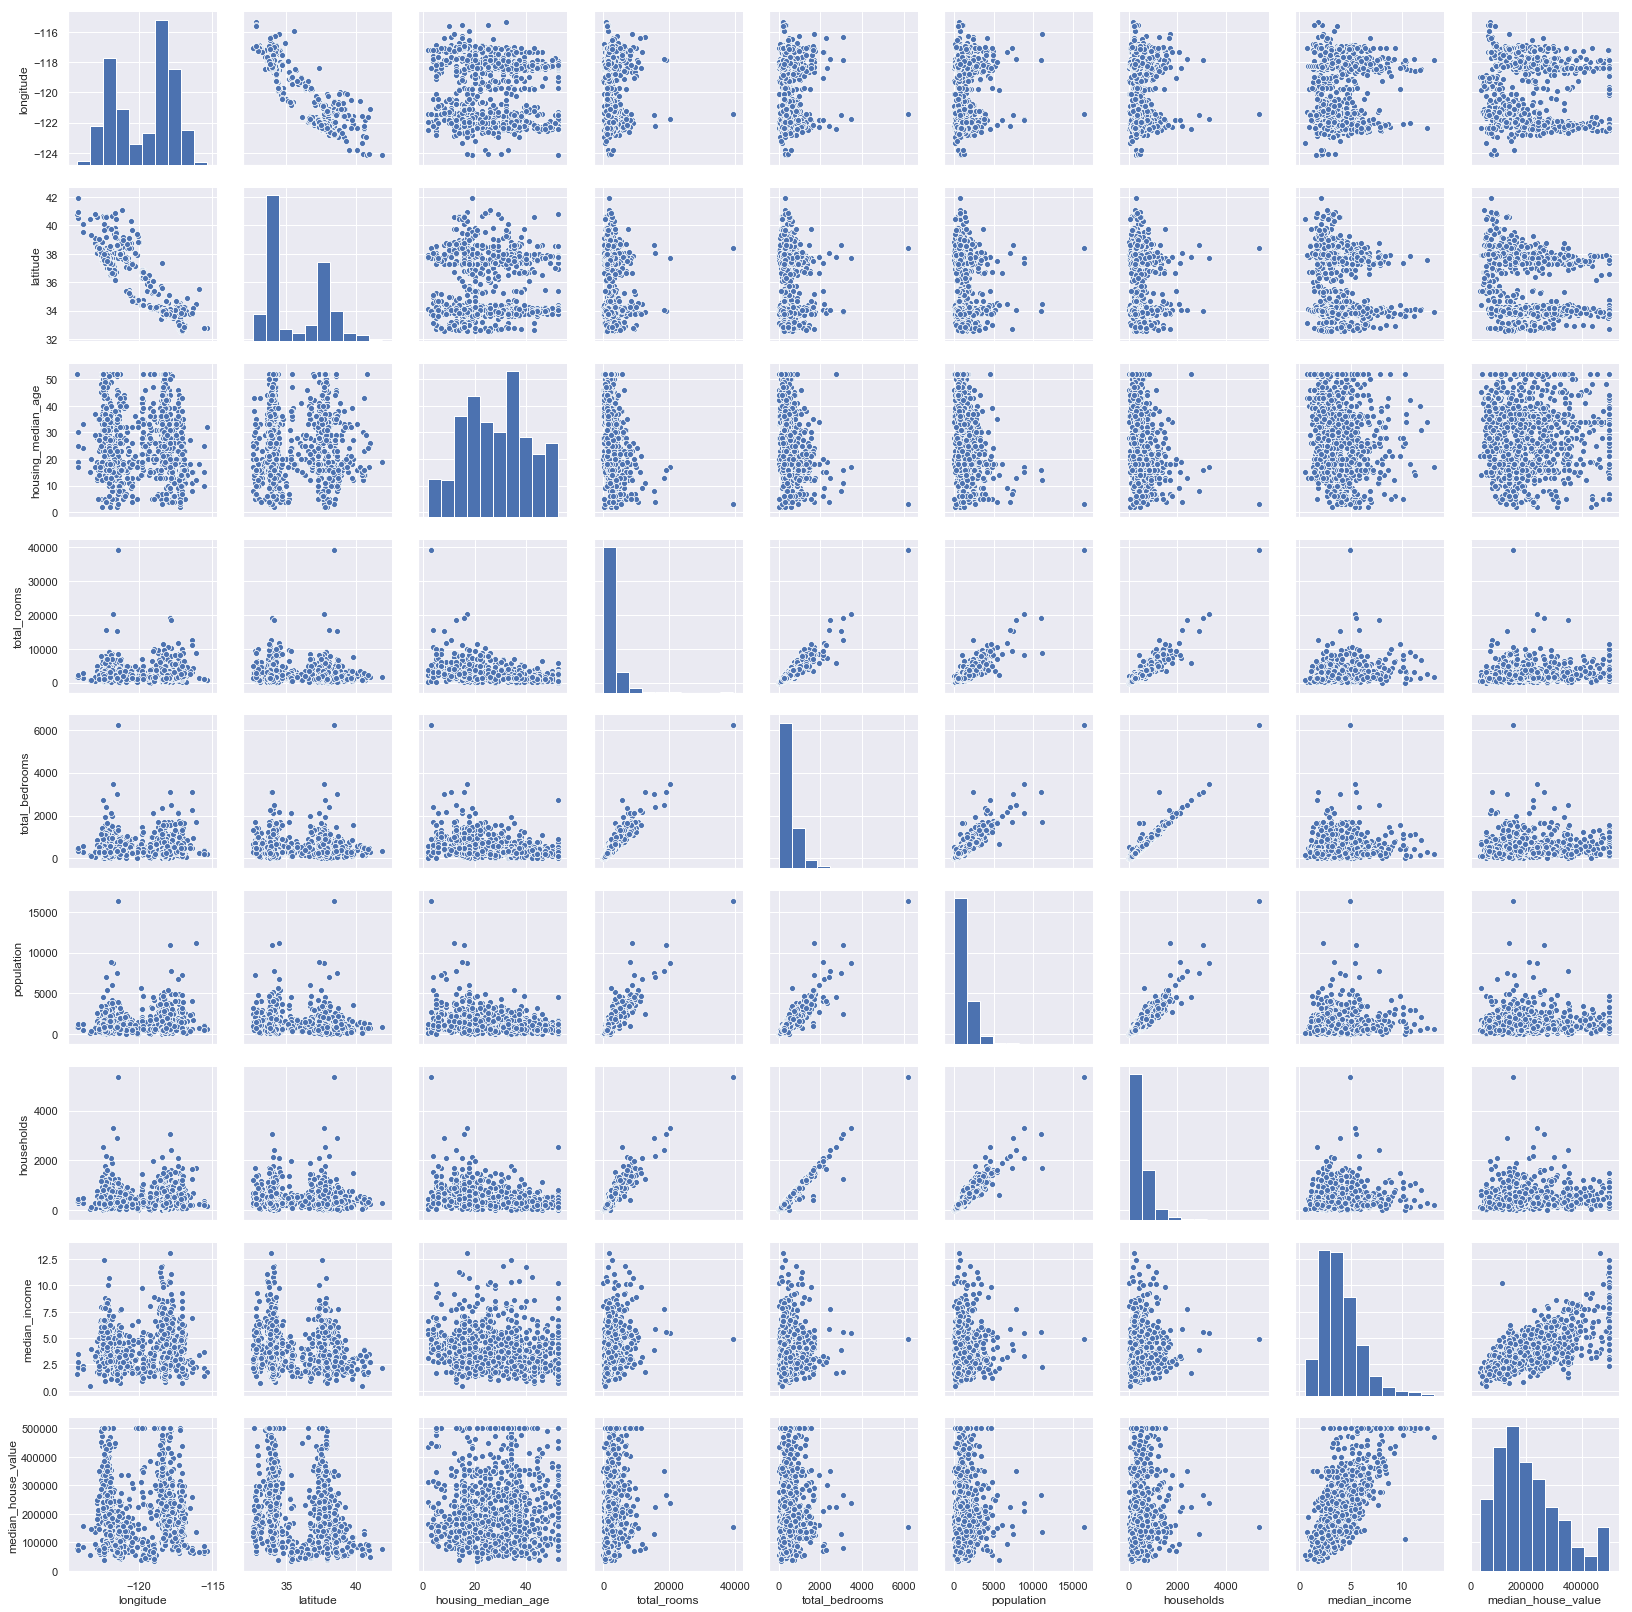

In [6]:
# for simplicity I drop the NaN values and the categorical column ocean_proximity
random_sample = data.dropna().drop(columns=['ocean_proximity']).sample(n=1000)
sns.pairplot(random_sample);

In [7]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Encode categorical features using one-hot-encoding
Der Einfachheit halber wenden wir manche Transformationen auf den gesammten Datensatz an.

In [8]:
# ONE-HOT-ENCODE ocean proximity
data_str_ocean = data['ocean_proximity'].values

# transform to numerical
data_ocean = LabelEncoder().fit_transform(data_str_ocean.ravel()).reshape(*data_str_ocean.shape)

# transform to binary
data_ocean_bin = OneHotEncoder().fit_transform(data_ocean.reshape(-1, 1)).toarray()

### Feature Engineering


*New categorical feature for making a distinction between districts with an average house age above 50 and those below*

In [9]:
data.loc[:,'old_house_district'] = 0
mask = (data['housing_median_age'] == 52)
data.loc[mask, 'old_house_district'] = 1

*New features calculated by ratios between datapoints*

In [10]:
data['persons_per_household'] = data['population'] / data['households']
data['room_ratio'] = data['total_bedrooms'] / data['total_rooms']

*New categorical feature descibing the median_income in levels*

In [11]:
data['rich_district'] = 0
mask = (data['median_income'] > 10)
data.loc[mask, 'rich_district'] = 1

In [12]:
data['poor_district'] = 0
mask = (data['median_income'] < 2)
data.loc[mask, 'poor_district'] = 1

*New features based on additional knowledge. Locations of large cities*

**LA**

Latitude:   34.052235

Longitude:  -118.243683

**SF**

Latitude:	37.773972

Longitude:	-122.431297

**San Diego**

Latitude	32.715736

Longitude	-117.161087


In [13]:
radius = 0.25
data['LA'] = 0
mask = (data['longitude'] > (-118.243683 - radius)) 
mask &= (data['longitude'] < (-118.243683 + radius)) 
mask &= (data['latitude'] > (34.052235 - radius)) 
mask &= (data['latitude'] < (34.052235 + radius))
data.loc[mask, 'LA'] = 1

data['SF'] = 0
mask = (data['longitude'] > (-122.431297 - radius)) 
mask &= (data['longitude'] < (-122.431297 + radius)) 
mask &= (data['latitude'] > (37.773972 - radius)) 
mask &= (data['latitude'] < (37.773972 + radius))
data.loc[mask, 'SF'] = 1

data['SD'] = 0
mask =  (data['longitude'] > (-117.161087 - radius)) 
mask &= (data['longitude'] < (-117.161087 + radius)) 
mask &= (data['latitude'] > (32.715736 - radius)) 
mask &= (data['latitude'] < (32.715736 + radius))
data.loc[mask, 'SD'] = 1

*Use a function transformer to apply non-linear transformations*

In [14]:
#data['median_income_log'] = data['median_income'].apply(np.log)
transformer = FunctionTransformer(np.log1p)
data['population_log_scales'] = transformer.transform(data['population'].values.reshape(-1, 1))

In [15]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,old_house_district,persons_per_household,room_ratio,rich_district,poor_district,LA,SF,SD,population_log_scales
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,0,2.555556,0.146591,0,0,0,1,0,5.777652
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,0,2.109842,0.155797,0,0,0,1,0,7.784057
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,1,2.802260,0.129516,0,0,0,1,0,6.208590
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,1,2.547945,0.184458,0,0,0,1,0,6.326149
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,1,2.181467,0.172096,0,0,0,1,0,6.338594


### Assign input and target values, split in test and train

In [16]:
y = data['median_house_value'].values
X = data.drop(columns=['median_house_value', 'ocean_proximity', 'population']).values
cols = data.drop(columns=['median_house_value', 'ocean_proximity', 'population']).columns

In [17]:
# Concat one-hot encoded features to input data
X = np.concatenate([X,data_ocean_bin], axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

*Replace housing_median_age with mean if set to 52 (encoding for over age 51)*

In [19]:
age_mean = X_train[:,2].mean()
inds = np.where(X_train[:,2] == 52)
X_train[inds,2] = age_mean

In [20]:
inds = np.where(X_test[:,2] == 52)
X_test[inds,2] = age_mean

### Fix NaN Values

In [21]:
#--- TRAIN
#Obtain mean of columns as you need, nanmean is just convenient.
col_mean = np.nanmean(X_train, axis=0)

#Find indicies that you need to replace in TRAIN
inds = np.where(np.isnan(X_train))

#Place column means in the indices. Align the arrays using take
X_train[inds] = np.take(col_mean, inds[1])

#--- TEST
#Find indicies that you need to replace in TEST
inds = np.where(np.isnan(X_test))

#Place column means in the indices. Align the arrays using take
X_test[inds] = np.take(col_mean, inds[1])


### Scale Inputs

In [22]:
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.fit_transform(X_test)

### Train model

In [23]:
lm = linear_model.LinearRegression()

In [24]:
# fit linear model to training subset 
model = lm.fit(X_train_minmax, y_train)
    
# make a prediction using the test subset
y_pred = lm.predict(X_test_minmax)

In [25]:
# Print Errors
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", np.sqrt(((y_test - y_pred) ** 2).mean()))
print("R2: ", r2_score(y_test, y_pred))
print("RMSE % of mean:", np.sqrt(((y_test - y_pred) ** 2).mean())/ y_test.mean())
print("Calibration:", y_pred.mean()/y_test.mean())

MSE:  4731011741.941282
RMSE:  68782.35051189573
R2:  0.6449766771866086
RMSE % of mean: 0.3318875247837509
Calibration: 0.9559025783621803


In [26]:
pd.DataFrame(lm.coef_, columns=['Coefficients'])

,Coefficients
0,-241940.578903
1,-209742.443613
2,22485.249287
3,-218756.502434
4,687772.946324
5,-180808.518603
6,683081.198278
7,43054.517246
8,-208366.208204
9,150370.738979


---

In [27]:
result = pd.DataFrame(X_test)
result['pred'] = y_pred
result['act'] = y_test
result['diff'] = abs(result['pred']-result['act'])
result.sort_values(['diff'],ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,pred,act,diff
140,-122.15,37.43,20.000000,11709.0,540.267139,3589.0,1.9045,0.0,2.118696,0.213002,...,0.0,8.936561,0.0,0.0,0.0,1.0,0.0,-75783.424542,375000.0,450783.424542
1250,-118.21,34.02,28.559662,22.0,7.000000,7.0,7.5752,1.0,7.857143,0.318182,...,0.0,4.025352,1.0,0.0,0.0,0.0,0.0,499453.365609,67500.0,431953.365609
1649,-118.08,34.15,28.000000,238.0,58.000000,31.0,0.4999,0.0,4.580645,0.243697,...,0.0,4.962845,0.0,1.0,0.0,0.0,0.0,72164.339521,500001.0,427836.660479
6420,-117.44,33.96,29.000000,124.0,22.000000,18.0,12.5381,0.0,2.777778,0.177419,...,0.0,3.931826,0.0,1.0,0.0,0.0,0.0,498187.819276,112500.0,385687.819276
872,-116.43,33.75,24.000000,2596.0,438.000000,237.0,3.7727,0.0,1.995781,0.168721,...,0.0,6.161207,0.0,1.0,0.0,0.0,0.0,140242.374572,500001.0,359758.625428
1140,-117.70,33.72,6.000000,211.0,51.000000,44.0,1.9659,0.0,2.840909,0.241706,...,0.0,4.836282,1.0,0.0,0.0,0.0,0.0,141039.119357,500001.0,358961.880643
4975,-117.66,33.48,22.000000,809.0,180.000000,157.0,2.3846,0.0,2.127389,0.222497,...,0.0,5.814131,1.0,0.0,0.0,0.0,0.0,142317.523302,500001.0,357683.476698
6665,-117.27,32.85,34.000000,2105.0,444.000000,406.0,2.3187,0.0,1.921182,0.210926,...,1.0,6.660575,0.0,0.0,0.0,0.0,1.0,133127.309192,488900.0,355772.690808
1865,-122.25,37.87,28.559662,609.0,236.000000,250.0,1.1696,1.0,5.396000,0.387521,...,0.0,7.207860,0.0,0.0,0.0,1.0,0.0,166939.638606,500001.0,333061.361394
429,-119.55,34.38,17.000000,1951.0,368.000000,350.0,2.7275,0.0,1.945714,0.188621,...,0.0,6.525030,1.0,0.0,0.0,0.0,0.0,167422.093402,500001.0,332578.906598
